# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
transform = transforms.Compose(
                                [
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307), (0.3081)),
                                transforms.Lambda(lambda x: x.view(-1)) # Flatten image
                                ]
                               )

# Create training set 
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
# Split the training data into training set and validation set
train_size = int(0.8 * len(train_dataset))  # 80% for training
valid_size = len(train_dataset) - train_size  # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
# define training and validation dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle = True)
validloader = DataLoader(valid_data, batch_size=32, shuffle = False)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
testloader = DataLoader(test_data, batch_size=32)

In [6]:
print(train_data[0][0].shape) # check the shape of the first image to make sure the flattening is done correctly

torch.Size([784])


In [7]:
print(len(validloader))
print(len(trainloader))
print(len(testloader))
len(train_dataset)

375
1500
313


60000

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I normalized the images by their mean and standard deviation so the images will habe a mean of zero and a standard deviation of 1. This is standardiszes the range of pixel values, making them comparable across different images. I also flattened the images as each pixel value will be an input the feedforward neural network.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [10]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
        
        image = images[i].view(28,28) # reverse flattening
        image - image * 0.3081 + 0.1307 # reverse normalization
    
        image = image.numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


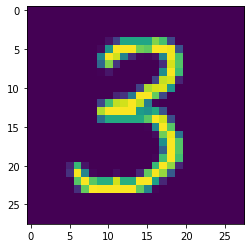

9


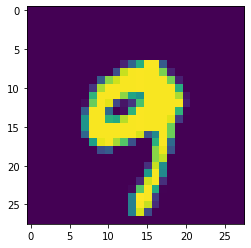

3


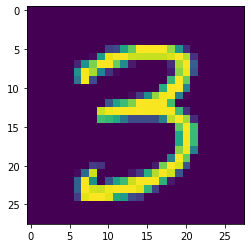

8


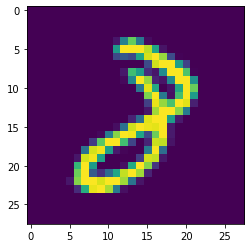

3


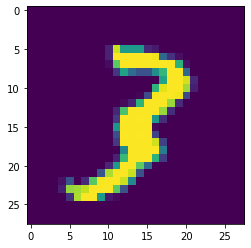

In [11]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [12]:
class MNIST_Mdl(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.output = F.log_softmax
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.output(x, dim=1)
        return x



Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [13]:
model = MNIST_Mdl()
criterion = nn.CrossEntropyLoss()  # For classification tasks
params = model.parameters()
optimizer = optim.SGD(params=params, lr=0.01, momentum=0.9)
model.to(device)

MNIST_Mdl(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [15]:
#Training the model
epochs = 5
print_every = 100  # Print every 100 batches

# Lists to keep track of metrics
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(epochs):
    running_loss = 0
    model.train()  # Set model to training mode

    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        logps = model(inputs)
        
        
        # Compute loss
        loss = criterion(logps, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print training loss and validate
        if (batch_idx + 1) % print_every == 0:
            # Calculate average training loss
            avg_train_loss = running_loss / print_every
            train_losses.append(avg_train_loss)
            running_loss = 0
            
            # Validation
            model.eval()  # Set model to evaluation mode
            valid_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    _, predicted = torch.max(ps, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
            avg_valid_loss = valid_loss / len(validloader)
            avg_valid_accuracy = correct / total
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(avg_valid_accuracy)
            
            print(f"Epoch {epoch + 1}/{epochs}.. "
                  f"Batch {batch_idx + 1}.. "
                  f"Train Loss: {avg_train_loss:.3f}.. "
                  f"Valid Loss: {avg_valid_loss:.3f}.. "
                  f"Valid Accuracy: {avg_valid_accuracy:.3f}")
            model.train()  # Set model back to training mode

print("Training complete.")

Epoch 1/5.. Batch 100.. Train Loss: 1.787.. Valid Loss: 1.044.. Valid Accuracy: 0.668
Epoch 1/5.. Batch 200.. Train Loss: 1.025.. Valid Loss: 0.815.. Valid Accuracy: 0.718
Epoch 1/5.. Batch 300.. Train Loss: 0.890.. Valid Loss: 0.765.. Valid Accuracy: 0.727
Epoch 1/5.. Batch 400.. Train Loss: 0.828.. Valid Loss: 0.750.. Valid Accuracy: 0.729
Epoch 1/5.. Batch 500.. Train Loss: 0.774.. Valid Loss: 0.575.. Valid Accuracy: 0.817
Epoch 1/5.. Batch 600.. Train Loss: 0.628.. Valid Loss: 0.510.. Valid Accuracy: 0.823
Epoch 1/5.. Batch 700.. Train Loss: 0.547.. Valid Loss: 0.487.. Valid Accuracy: 0.831
Epoch 1/5.. Batch 800.. Train Loss: 0.547.. Valid Loss: 0.463.. Valid Accuracy: 0.837
Epoch 1/5.. Batch 900.. Train Loss: 0.519.. Valid Loss: 0.437.. Valid Accuracy: 0.845
Epoch 1/5.. Batch 1000.. Train Loss: 0.514.. Valid Loss: 0.432.. Valid Accuracy: 0.844
Epoch 1/5.. Batch 1100.. Train Loss: 0.546.. Valid Loss: 0.427.. Valid Accuracy: 0.845
Epoch 1/5.. Batch 1200.. Train Loss: 0.504.. Valid L

Plot the training loss (and validation loss/accuracy, if recorded).

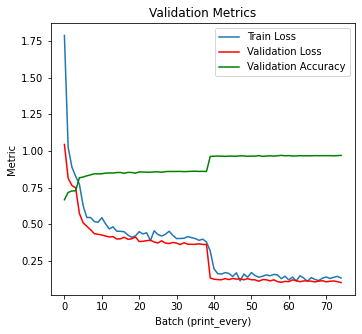

In [17]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Batch (print_every)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation metrics
plt.subplot(1, 2, 1)
plt.plot(valid_losses, label='Validation Loss', color='red')
plt.plot(valid_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Batch (print_every)')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.legend()

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader: # 26 batches with a batch size of 32
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
                    
        test_loss += batch_loss.item()
                    
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 0.098.. Test accuracy: 0.972


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

# Did not do this step as I am quite satisfied with my results.

## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epochs': epochs,
              'learning_rate': 0.1,
              'momentum': 0.9
             }

torch.save(checkpoint, 'model_checkpoint.pth')
print("Model Checkpoint saved successfully.")

Model Checkpoint saved successfully.
